In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

from sklearn.model_selection import train_test_split

import argparse

import models
import metrics
import utils
from train import *
from data import BUSIDataset

config = argparse.Namespace()

config.model = 'Feature_Fusion_UNet'

config.SIZE = 128
config.batch_size = 8
config.num_workers = 8
config.n_channels = 1
config.lr = 0.0001
config.min_lr = 0.00001
config.epochs = 50
config.early_stopping = 50
config.patience = config.early_stopping
config.base_dir = ''
config.root_path = os.path.join(config.base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
config.semantic = False
config.device = torch.device('cuda:0')
config.classes = ['normal', 'benign', 'malignant']
config.labels = []
config.num_classes = 3 if config.semantic else 1
config.loss = 'BCEDiceLoss'
config.optimizer = 'Adam'
config.scheduler = 'CosineAnnealingLR'
config.weight_decay = 1e-4
config.momentum = 0.9
config.nesterov = False
config.seed = 4

if config.semantic:
    config.labels = config.classes
else:
    config.labels = ['cancer']

# write a function that sets the seed of all the libraries
def set_seed():
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    random.seed(config.seed)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
def run_model(config):
    if config.model is not None and not os.path.exists('model_files/%s' % config.model):
        os.makedirs('model_files/%s' % config.model)

    print('-' * 20)
    for key, value in config.__dict__.items():
        print('%s: %s' % (key, value))
    print('-' * 20)


    criterion = metrics.__dict__[config.loss]().cuda()
    model = models.__dict__[config.model](n_channels=config.n_channels,
                                            n_classes=config.num_classes).cuda()


    summary(model, (config.n_channels, config.SIZE, config.SIZE))

    params = filter(lambda p: p.requires_grad, model.parameters())
    num_params = sum([p.numel() for p in model.parameters()])

    if config.optimizer == 'Adam':
        optimizer = optim.Adam(
            params, lr=config.lr, weight_decay=config.weight_decay)
    elif config.optimizer == 'SGD':
        optimizer = optim.SGD(params, lr=config.lr, momentum=config.momentum,
                                nesterov=config.nesterov, weight_decay=config.weight_decay)

    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config.epochs, eta_min=config.min_lr)
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.factor, patience=config.patience,
                                                    verbose=1, min_lr=config.min_lr)
    else:
        scheduler = None

    image_paths, mask_paths = utils.load_dataset(config.root_path)
    print(f"Total Images: {len(image_paths)}, Masks: {len(mask_paths)}")

    train_transform = Compose([
        RandomRotate90(),
        Flip(),
    ])

    # image_paths, mask_paths = image_paths[:20], mask_paths[:20] # overfitting
    X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths,  test_size=0.4, random_state=config.seed)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=config.seed)
    # split X_test, y_test into validation and test, 50-50

    train_dataset = BUSIDataset(image_paths=X_train, mask_paths=y_train, size=config.SIZE, transform=train_transform)
    val_dataset = BUSIDataset(image_paths=X_val, mask_paths=y_val, size=config.SIZE, transform=None)
    test_dataset = BUSIDataset(image_paths=X_test, mask_paths=y_test, size=config.SIZE, transform=None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=False)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=False)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=False)

    log = OrderedDict([
        ('train_lr', []),
        ('train_loss', []),
        ('train_iou', []),
        ('train_dice', []),
        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
    ])

    best_dice = 0
    trigger = 0
    total_trained_epochs = 0
    for epoch in range(config.epochs):
        print('Epoch [%d/%d]' % (epoch, config.epochs))
        total_trained_epochs += 1

        # train for one epoch
        train_log = train(train_loader, model, criterion, optimizer)
        # evaluate on validation set
        val_log = validate(val_loader, model, criterion)

        if config.scheduler == 'CosineAnnealingLR':
            scheduler.step()
        elif config.scheduler == 'ReduceLROnPlateau':
            scheduler.step(val_log['loss'])

        print(f"loss {train_log['loss']:.4f} - iou {train_log['iou']:.4f} - dice {train_log['dice']:.4f} \
                - val_loss {val_log['loss']:.4f} - val_iou {val_log['iou']:.4f} - val_dice {val_log['dice']:.4f}") 

        print(train_log, val_log)
        log['train_lr'].append(config.lr)
        log['train_loss'].append(train_log['loss'])
        log['train_iou'].append(train_log['iou'])
        log['train_dice'].append(train_log['dice'])
        log['val_loss'].append(val_log['loss'])
        log['val_iou'].append(val_log['iou'])
        log['val_dice'].append(val_log['dice'])

        pd.DataFrame(log).to_csv('model_files/%s/log.csv' %
                                    config.model, index=False)

        trigger += 1

        if val_log['dice'] > best_dice:
            torch.save(model.state_dict(), 'model_files/%s/model.pth' %
                        config.model)
            best_dice = val_log['dice']
            print("=> saved best model")
            trigger = 0

        # early stopping
        if config.early_stopping >= 0 and trigger >= config.early_stopping:
            print("=> early stopping")
            break

        torch.cuda.empty_cache()

    print(f"Val Loss: {log['val_loss'][-1]:.4f} - Val IOU: {log['val_iou'][-1]:.4f} - Val Dice: {log['val_dice'][-1]:.4f}")

    model.load_state_dict(torch.load('model_files/%s/model.pth' % config.model))
    test_log = validate(test_loader, model, criterion)
    print(f"Test loss {test_log['loss']:.4f} - Test IoU {test_log['iou']:.4f} - Test Dice {test_log['dice']:.4f}")
    test_log_df = pd.DataFrame({'model': [config.model], 'epochs': [total_trained_epochs], 'size': [config.SIZE], 'params': [num_params], 'test_dice': [test_log['dice']], 'test_iou': [test_log['iou']], 'test_loss': [test_log['loss']], 'seed' : [config.seed]})
    # append test_log_df to test_log.csv
    test_log_df.to_csv('test_log.csv', mode='a', header=False, index=False)

In [3]:
seeds = [4, 9, 17, 18, 38]
# seeds = [4]

for seed in seeds:
    config.seed = seed
    set_seed()
    run_model(config)

--------------------
model: Feature_Fusion_UNet
SIZE: 128
batch_size: 8
num_workers: 8
n_channels: 1
lr: 0.0001
min_lr: 1e-05
epochs: 50
early_stopping: 50
patience: 50
base_dir: 
root_path: breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/
semantic: False
device: cuda:0
classes: ['normal', 'benign', 'malignant']
labels: ['cancer']
num_classes: 1
loss: BCEDiceLoss
optimizer: Adam
scheduler: CosineAnnealingLR
weight_decay: 0.0001
momentum: 0.9
nesterov: False
seed: 4
--------------------


/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/lowlevel.py:323: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  y = F.conv_transpose2d(lo, g0, stride=s, padding=pad, groups=C) + \


Layer (type:depth-idx)                   Output Shape              Param #
├─WaveletUpsampling: 1-1                 [-1, 1, 256, 256]         --
|    └─DWTInverse: 2-1                   [-1, 1, 256, 256]         --
├─WaveletChannels: 1-2                   [-1, 1, 128, 128]         --
|    └─DWTForward: 2-2                   [-1, 1, 128, 128]         --
├─DoubleConv: 1-3                        [-1, 64, 128, 128]        --
|    └─Sequential: 2-3                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        576
|    |    └─BatchNorm2d: 3-2             [-1, 64, 128, 128]        128
|    |    └─ReLU: 3-3                    [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 128, 128]        128
|    |    └─ReLU: 3-6                    [-1, 64, 128, 128]        --
├─DoubleConv: 1-4                        [-1, 64, 128, 128]        (recursive)

100%|██████████| 17/17 [00:03<00:00,  5.12it/s, loss=1.36, iou=0.223, dice=0.356]


loss 1.0823 - iou 0.2444 - dice 0.3804                 - val_loss 1.3604 - val_iou 0.2229 - val_dice 0.3557
OrderedDict({'loss': 1.0823422590481866, 'iou': 0.24436389939115746, 'dice': 0.38043209378618514}) OrderedDict({'loss': 1.360359324965366, 'iou': 0.2229122936343827, 'dice': 0.3557242162791496})
=> saved best model
Epoch [1/50]


100%|██████████| 17/17 [00:03<00:00,  5.13it/s, loss=1.07, iou=0.264, dice=0.41] 


loss 0.9394 - iou 0.3797 - dice 0.5427                 - val_loss 1.0691 - val_iou 0.2641 - val_dice 0.4103
OrderedDict({'loss': 0.9394000025139642, 'iou': 0.37971560333647797, 'dice': 0.5427365222538819}) OrderedDict({'loss': 1.069099224815073, 'iou': 0.26405090355120253, 'dice': 0.41033722299543796})
=> saved best model
Epoch [2/50]


100%|██████████| 17/17 [00:03<00:00,  5.12it/s, loss=1.08, iou=0.187, dice=0.309]


loss 0.8829 - iou 0.4267 - dice 0.5907                 - val_loss 1.0804 - val_iou 0.1866 - val_dice 0.3089
OrderedDict({'loss': 0.8829335447439214, 'iou': 0.42670664078972875, 'dice': 0.5906672100649526}) OrderedDict({'loss': 1.080365544141725, 'iou': 0.18656190035050246, 'dice': 0.3089344854989586})
Epoch [3/50]


100%|██████████| 17/17 [00:03<00:00,  5.11it/s, loss=0.908, iou=0.366, dice=0.527]


loss 0.8425 - iou 0.4528 - dice 0.6166                 - val_loss 0.9082 - val_iou 0.3661 - val_dice 0.5274
OrderedDict({'loss': 0.84251020802665, 'iou': 0.4528147642419287, 'dice': 0.6165667322456234}) OrderedDict({'loss': 0.908195627290149, 'iou': 0.3661483398230072, 'dice': 0.5274147961146461})
=> saved best model
Epoch [4/50]


100%|██████████| 17/17 [00:03<00:00,  5.10it/s, loss=0.926, iou=0.391, dice=0.551]


loss 0.8075 - iou 0.4734 - dice 0.6338                 - val_loss 0.9261 - val_iou 0.3914 - val_dice 0.5515
OrderedDict({'loss': 0.8075165748596191, 'iou': 0.4733694694110373, 'dice': 0.6337879846427948}) OrderedDict({'loss': 0.9261421662892482, 'iou': 0.3914147747204371, 'dice': 0.5514917551543356})
=> saved best model
Epoch [5/50]


100%|██████████| 17/17 [00:03<00:00,  5.09it/s, loss=0.882, iou=0.41, dice=0.57]  


loss 0.7773 - iou 0.4871 - dice 0.6488                 - val_loss 0.8815 - val_iou 0.4102 - val_dice 0.5695
OrderedDict({'loss': 0.7772869049888296, 'iou': 0.487064917189215, 'dice': 0.6487703016567127}) OrderedDict({'loss': 0.8815460787263028, 'iou': 0.4101952076854572, 'dice': 0.5695200087439426})
=> saved best model
Epoch [6/50]


100%|██████████| 17/17 [00:03<00:00,  5.10it/s, loss=0.876, iou=0.374, dice=0.532]


loss 0.7537 - iou 0.4967 - dice 0.6562                 - val_loss 0.8763 - val_iou 0.3736 - val_dice 0.5324
OrderedDict({'loss': 0.7536968465932866, 'iou': 0.49668035378474135, 'dice': 0.6562032378416188}) OrderedDict({'loss': 0.8762769652891529, 'iou': 0.3736442505753798, 'dice': 0.5324081435281262})
Epoch [7/50]


100%|██████████| 17/17 [00:03<00:00,  5.09it/s, loss=0.914, iou=0.357, dice=0.51] 


loss 0.7219 - iou 0.5068 - dice 0.6628                 - val_loss 0.9144 - val_iou 0.3571 - val_dice 0.5096
OrderedDict({'loss': 0.7219265060326487, 'iou': 0.5068007855729835, 'dice': 0.6627630981336685}) OrderedDict({'loss': 0.9144404567489328, 'iou': 0.35710071547293737, 'dice': 0.509620667899222})
Epoch [8/50]


100%|██████████| 17/17 [00:03<00:00,  5.05it/s, loss=0.777, iou=0.485, dice=0.639]


loss 0.7202 - iou 0.4955 - dice 0.6517                 - val_loss 0.7775 - val_iou 0.4849 - val_dice 0.6392
OrderedDict({'loss': 0.7201628500653297, 'iou': 0.4954599423165046, 'dice': 0.651650714107578}) OrderedDict({'loss': 0.777455679205961, 'iou': 0.4849007134027878, 'dice': 0.639218707194242})
=> saved best model
Epoch [9/50]


100%|██████████| 17/17 [00:03<00:00,  5.14it/s, loss=0.852, iou=0.41, dice=0.568] 


loss 0.6818 - iou 0.5247 - dice 0.6799                 - val_loss 0.8523 - val_iou 0.4102 - val_dice 0.5683
OrderedDict({'loss': 0.6817941714807884, 'iou': 0.5246807824155659, 'dice': 0.6798976834101236}) OrderedDict({'loss': 0.8522742746412292, 'iou': 0.41022449708552977, 'dice': 0.5683012644786429})
Epoch [10/50]


100%|██████████| 17/17 [00:03<00:00,  4.75it/s, loss=0.778, iou=0.403, dice=0.565]


loss 0.6600 - iou 0.5396 - dice 0.6910                 - val_loss 0.7780 - val_iou 0.4027 - val_dice 0.5647
OrderedDict({'loss': 0.6599872941823349, 'iou': 0.5395985677432477, 'dice': 0.6909990509569663}) OrderedDict({'loss': 0.7780211179755455, 'iou': 0.4027428552912642, 'dice': 0.5646634052505453})
Epoch [11/50]


100%|██████████| 17/17 [00:03<00:00,  5.04it/s, loss=0.734, iou=0.442, dice=0.596]


loss 0.6438 - iou 0.5426 - dice 0.6948                 - val_loss 0.7339 - val_iou 0.4419 - val_dice 0.5962
OrderedDict({'loss': 0.6438020406310091, 'iou': 0.5425804973195273, 'dice': 0.6947772538112765}) OrderedDict({'loss': 0.7338834372601768, 'iou': 0.44190481969802226, 'dice': 0.5962043128724903})
Epoch [12/50]


100%|██████████| 17/17 [00:03<00:00,  4.95it/s, loss=0.715, iou=0.467, dice=0.63] 


loss 0.6179 - iou 0.5655 - dice 0.7137                 - val_loss 0.7152 - val_iou 0.4668 - val_dice 0.6295
OrderedDict({'loss': 0.6179117769310155, 'iou': 0.5654675573940763, 'dice': 0.7136850319730317}) OrderedDict({'loss': 0.7151692643646121, 'iou': 0.4667785228034119, 'dice': 0.6295482243488199})
Epoch [13/50]


100%|██████████| 17/17 [00:03<00:00,  4.96it/s, loss=0.688, iou=0.486, dice=0.643]


loss 0.6004 - iou 0.5700 - dice 0.7190                 - val_loss 0.6879 - val_iou 0.4864 - val_dice 0.6435
OrderedDict({'loss': 0.6004276542933946, 'iou': 0.5699774608943059, 'dice': 0.7190278933710968}) OrderedDict({'loss': 0.6879187242467274, 'iou': 0.48641324947369396, 'dice': 0.6434618245555157})
=> saved best model
Epoch [14/50]


100%|██████████| 17/17 [00:03<00:00,  5.08it/s, loss=0.657, iou=0.459, dice=0.62] 


loss 0.5682 - iou 0.5971 - dice 0.7379                 - val_loss 0.6574 - val_iou 0.4591 - val_dice 0.6197
OrderedDict({'loss': 0.5682023579312354, 'iou': 0.5971123739099644, 'dice': 0.7378876369289334}) OrderedDict({'loss': 0.6573734348134477, 'iou': 0.45908379039676483, 'dice': 0.6196541018116677})
Epoch [15/50]


100%|██████████| 17/17 [00:03<00:00,  5.06it/s, loss=0.697, iou=0.454, dice=0.605]


loss 0.5599 - iou 0.5838 - dice 0.7307                 - val_loss 0.6969 - val_iou 0.4543 - val_dice 0.6051
OrderedDict({'loss': 0.5598646537544801, 'iou': 0.5838402882994875, 'dice': 0.7306824138858707}) OrderedDict({'loss': 0.6969028646631759, 'iou': 0.45426881509918626, 'dice': 0.605103285831423})
Epoch [16/50]


100%|██████████| 17/17 [00:03<00:00,  5.09it/s, loss=0.669, iou=0.459, dice=0.618]


loss 0.5481 - iou 0.5908 - dice 0.7325                 - val_loss 0.6689 - val_iou 0.4585 - val_dice 0.6179
OrderedDict({'loss': 0.5481275793203374, 'iou': 0.5907761495193021, 'dice': 0.7325126353540303}) OrderedDict({'loss': 0.6689217820648075, 'iou': 0.4585015029958879, 'dice': 0.6179102551200045})
Epoch [17/50]


100%|██████████| 17/17 [00:03<00:00,  5.05it/s, loss=0.602, iou=0.559, dice=0.709]


loss 0.5243 - iou 0.6102 - dice 0.7512                 - val_loss 0.6021 - val_iou 0.5593 - val_dice 0.7088
OrderedDict({'loss': 0.5243449487636999, 'iou': 0.6102259175691186, 'dice': 0.7511921746885173}) OrderedDict({'loss': 0.6020644621331562, 'iou': 0.5593028368738818, 'dice': 0.7087824829448419})
=> saved best model
Epoch [18/50]


 49%|████▉     | 24/49 [00:09<00:10,  2.47it/s, loss=0.498, iou=0.636, dice=0.77] 

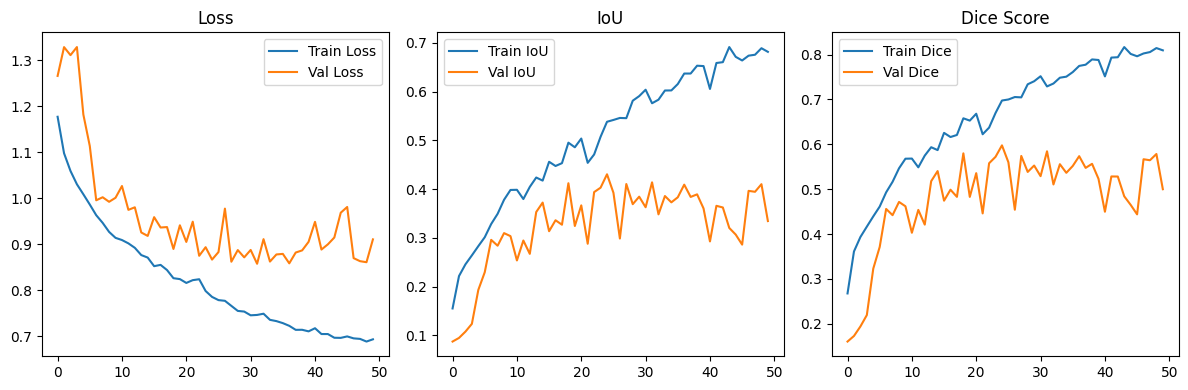

In [ ]:
def plot_curves(model_name):
    log_data = pd.read_csv('model_files/%s/log.csv' % model_name)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(log_data['train_loss'], label='Train Loss')
    plt.plot(log_data['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Plot training and validation IoU
    plt.subplot(1, 3, 2)
    plt.plot(log_data['train_iou'], label='Train IoU')
    plt.plot(log_data['val_iou'], label='Val IoU')
    plt.title('IoU')
    plt.legend()

    # Plot training and validation Dice score
    plt.subplot(1, 3, 3)
    plt.plot(log_data['train_dice'], label='Train Dice')
    plt.plot(log_data['val_dice'], label='Val Dice')
    plt.title('Dice Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves('Wavelet_UNet_All')

In [ ]:
# # set seeds of 4, 9, 17, 18, 38
# seeds = [4, 9, 17, 18, 38]
# model_names = ['UNet', 'Wavelet_UNet']

# for seed in seeds:
#     for model_name in model_names:
#         config.seed = seed
#         config.model = model_name
#         set_seed()
#         run_model(config)